<a href="https://colab.research.google.com/github/nisanuro/CNG562-Assignment-3/blob/KMeans/CNG562_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn import metrics, datasets, preprocessing
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def correlation_map(df):
    plt.figure(figsize=(20,12)) 

    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='hot')
    plt.show()

In [0]:
def filter_features(data, feature_indexes):
		# eliminate above column indices from the data and return new set
		filtered_data = np.delete(data, feature_indexes, axis=1)

		return filtered_data

In [0]:
def fourError(X, Y, model, r, future_scaling):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = r, stratify=Y)
    
    if(future_scaling):
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    
    Train_x, TrainDev_x, Train_y, TrainDev_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=0, stratify=Y_train)
    Dev_x, Test_x, Dev_y, Test_y = train_test_split(X_test, Y_test, test_size=0.5, random_state=0, stratify=Y_test)

    model.fit(Train_x, Train_y)

    y_true, trainDev_pred = TrainDev_y, model.predict(TrainDev_x)

    print("\nTrain-Train Dev,   e1:", metrics.mean_squared_error(TrainDev_y, trainDev_pred))
    print("Accuracy: ", 1 - metrics.mean_squared_error(TrainDev_y, trainDev_pred),"\n")

    y_true, dev_pred = Dev_y, model.predict(Dev_x)
    print("Train-Dev,   e2", metrics.mean_squared_error(Dev_y, dev_pred))
    print("Accuracy: ", 1 - metrics.mean_squared_error(Dev_y, dev_pred),"\n")

    y_true, test_pred = Test_y, model.predict(Test_x)
    print("Train-Test,   e3: ", metrics.mean_squared_error(Test_y, test_pred))
    print("Accuracy: ", 1 - metrics.mean_squared_error(Test_y, test_pred),"\n")

    y_true, devTest_pred = Y_test, model.predict(X_test)
    print("Train-(Dev+Test),   e4: ", metrics.mean_squared_error(Y_test, devTest_pred))
    print("Accuracy: ", 1 - metrics.mean_squared_error(Y_test, devTest_pred),"\n")

In [0]:
def vis_all_feat(data, class_):
    for col_ind in range(data.shape[1]):
		    print("Viewing Feature #{0}".format(str(col_ind)))
		    vis_single_feat(data, class_, col_ind)

In [0]:
def vis_single_feat(data, class_, ind):
	  # create graph of classification and feature values	
	  plt.figure(100) # display two plots on separate figures
	  df = pd.DataFrame(data)
	  feat_vals = df.iloc[:, ind]
	  plt.scatter(feat_vals, class_)
	  plt.title("Plot of Feature {0}".format(str(ind)))
	  plt.xlabel("Feature Value")
	  plt.ylabel("Classification")
  
	  # create bar graph of mean feature values for each classification
	  plt.figure(200)
	  plt.title("Mean Values of Feature {0}".format(str(ind)))
	  plt.xlabel("Classification")
	  plt.ylabel("Mean Feature Value")
	  mean_df = pd.concat([df.iloc[:, ind], pd.Series(class_)], axis=1)
	  mean_df.columns = ["values", "classif"]	
	  mean_df.groupby("classif", as_index=False)["values"].mean().loc[:,"values"].plot(kind='bar')
  
	  plt.show()

In [0]:
def ElbowMethod(data):
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k, n_init=10, n_jobs=-1, random_state = 0)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
    
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [0]:
def SilhouetteAnalysis(X, Y):
    range_n_clusters = [2, 3, 4]

    for n_clusters in range_n_clusters:
        
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1,random_state = 0)
        cluster_labels = clusterer.fit_predict(X)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)


        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')
        
    plt.show()

In [0]:
def Kmeans(X_train, X_test, Y_train, Y_test):

    model = KMeans(n_clusters=2, n_init=10, n_jobs=-1, random_state = 0)
    model.fit(X_train)

    pred = model.predict(X_test)
    #print(confusion_matrix(Y_test, pred))
    
    correct = 0
    for i in range(len(X_train)):
        predict_me = np.array(X_train[i].astype(float))
        predict_me = predict_me.reshape(-1, len(predict_me))
        prediction = model.predict(predict_me)
        if prediction[0] == Y_train[i]:
            correct += 1

    print(correct/len(X))
    

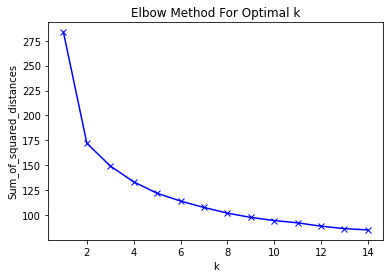

For n_clusters = 2 The average silhouette_score is : 0.3806967353690942
For n_clusters = 3 The average silhouette_score is : 0.3234545004010265
For n_clusters = 4 The average silhouette_score is : 0.3239019322177605


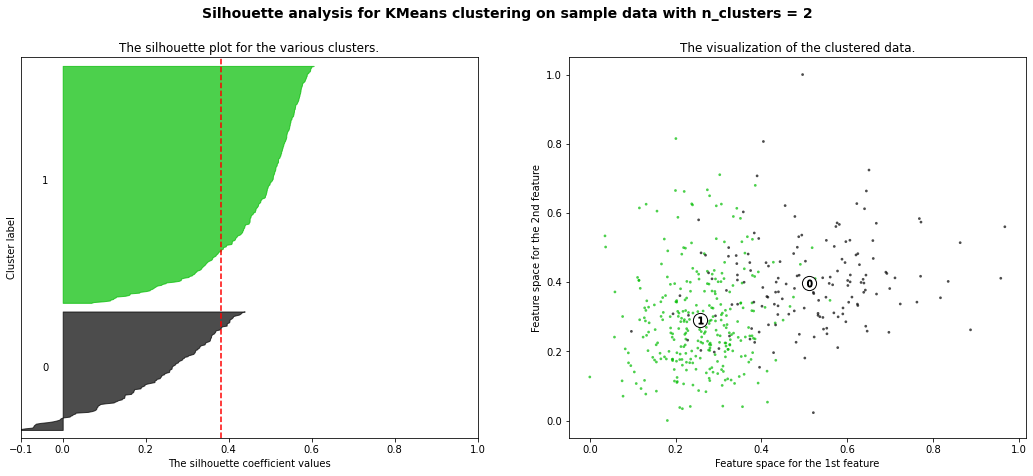

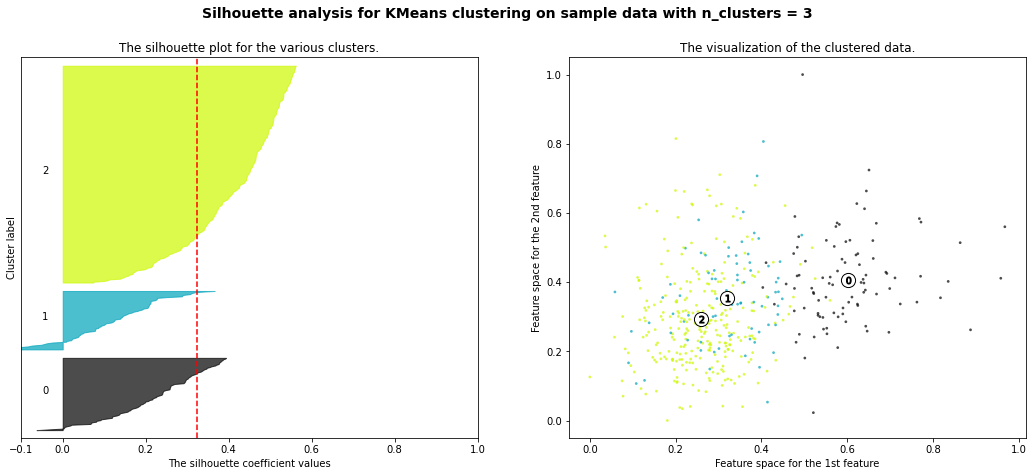

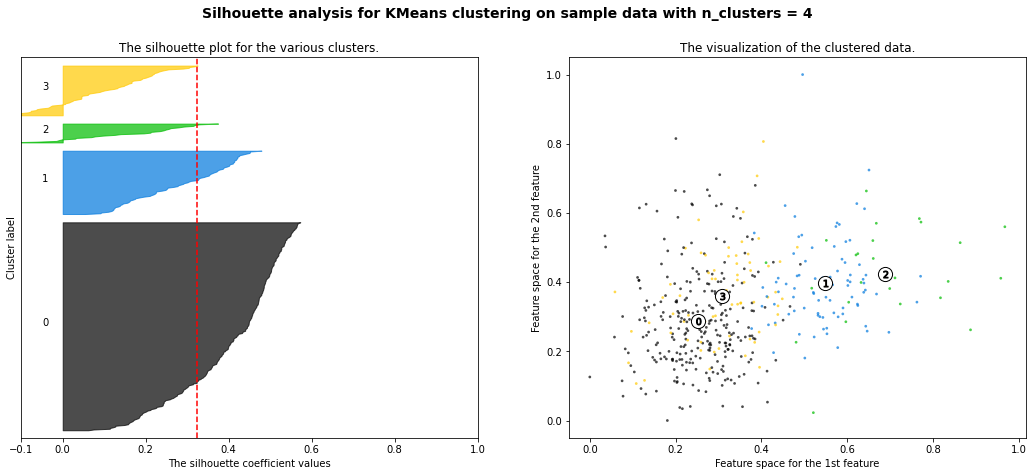

0.7486818980667839


In [10]:
if __name__ == '__main__':

    breast_cancer = datasets.load_breast_cancer()
    X = breast_cancer.data
    Y = breast_cancer.target
    '''
    X = filter_features(X, [2, 3, 20, 22, 23, 12, 13])
    
    #vis_all_feat(X, Y)
    X = filter_features(X, [1, 2, 6, 7, 9, 10, 14, 15])
    #X = filter_features(X, [2, 3])
    '''

    mms = MinMaxScaler()
    mms.fit(X)
    X = mms.transform(X)


    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

    
    #correlation_map(pd.DataFrame(X))

    ElbowMethod(X_train) 
    SilhouetteAnalysis(X_train, Y_train)

    Kmeans(X_train, X_test, Y_train, Y_test)

    